In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import numpy as np
import dateutil
import time

plt.rcParams['figure.figsize'] = (20, 10)

In [2]:
def read_pidstat(path, ncores=32):
    data = dict()
    reading_values = False

    with open(path) as fd:
        for line in fd:
            if line[0] == '#':
                keys = line[1:].split()
                for k in keys:
                    if k not in data:
                        data[k] = []
                reading_values = True
            elif reading_values:
                values = line.split()
                for k, v in zip(keys, values):
                    try:
                        data[k].append(float(v))
                    except:
                        data[k].append(v)
    for k, v in data.items():
        data[k] = np.array(v)
    data['Time'] = data['Time'] - data['Time'][0]
    data['CPU'] = (data['%CPU'] / 100) * ncores
    return data

In [3]:
def read_sourcex_logs(path):
    # Low-level parsing
    log = dict(timestamp=[], logger=[], level=[], message=[])
    with open(path) as fd:
        for line in fd:
            try:
                timestamp, logger, level, _, message = line.split(maxsplit=4)
                log['timestamp'].append(dateutil.parser.parse(timestamp))
                log['logger'].append(logger)
                log['level'].append(level)
                log['message'].append(message.strip())
            except:
                pass
    start = log['timestamp'][0]
    log['Time'] = np.array([(t - start).seconds for t in log['timestamp']])
    # Details
    data = dict(
        background=[],
        segmentation=[None, None],
        deblending=[None, None],
        measurement=[None, None],
    )
    deblending_max = 0
    measured_max = 0
    for m, t in zip(log['message'], log['Time']):
        # Background modelling
        if m.startswith('Background for image'):
            data['background'].append(t)
        # Segmentation
        elif m.startswith('Segmentation'):
            _, line, _, total, _ = m.split()
            # First line done, ~approximation for start
            if int(line) > 0 and data['segmentation'][0] is None:
                data['segmentation'][0] = t
            # Last line done, end
            if int(line) == int(total) and data['segmentation'][1] is None:
                data['segmentation'][1] = t
        # Measurement
        elif m.startswith('Measured'):
            # First done, ~approximation for start
            # Move end time until the counting does not increase
            aux = m.split()
            if len(aux) > 2:
                count = int(aux[1])
                if data['measurement'][0] is None:
                    data['measurement'][0] = t
                if count > measured_max:
                    data['measurement'][1] = t
                    measured_max = count
        # Deblending
        elif m.startswith('Deblended'):
            _, count = m.split()
            count = int(count)
            # First reported, ~approximation for start
            # Move end time until the counting does not increase
            if count > deblending_max:
                if deblending_max == 0:
                    data['deblending'][0] = t
                data['deblending'][1] = t
                deblending_max = count
    return data

In [4]:
def plot_perf(pidstat, log, cpu_config=32, ax=None):
    if ax is None:
        ax = plt.gca()
        
    lcpu = ax.plot(pidstat['Time'], pidstat['CPU'], label='CPU')
    lconfig = ax.axhline(cpu_config, color='red', linestyle='--', label='thread-number')
    lbg = ax.vlines(log['background'], 0, cpu_config, color='black', linestyle='--', label='Background done')
    ls = ax.axvspan(*log['segmentation'], ymin=0, ymax=0.33, color='orange', label='Segmentation')
    ld = ax.axvspan(*log['deblending'], ymin=0.33, ymax=0.66, color='pink', label='Deblending')
    lm = ax.axvspan(*log['measurement'], ymin=0.66, ymax=1., color='lightgreen', label='Measurement')
    ax.set_ylabel('Number of CPU')
    
    # Moving average
    ma = np.convolve(pidstat['CPU'], np.ones(60), 'same')/60
    ax.plot(pidstat['Time'], ma, linestyle='-', color='cyan', alpha=0.5)
    
    formatter = FuncFormatter(lambda s, x: time.strftime('%H:%M:%S', time.gmtime(s)))
    ax.xaxis.set_major_formatter(formatter)
    ax.set_xlabel('Time')
    
    lns = lcpu + [lconfig, lbg, ls, ld, lm]
    
    if 'kB_rd/s' in pidstat:
        ax2 = ax.twinx()
        lio = ax2.plot(pidstat['Time'], pidstat['kB_rd/s']/1024, linestyle=':', color='gray', label='Read I/O')
        ax2.set_ylabel('MB/s')
        lns.extend(lio)
    
    labels = [l.get_label() for l in lns]
    ax.legend(lns, labels)
    ax.grid()

# 32 cores

In [5]:
dev = read_pidstat('/home/aalvarez/Work/Data/SxPerf/st-dev-32.stat', 64)
dev_log = read_sourcex_logs('/home/aalvarez/Work/Data/SxPerf/sourcex-dev-32.log')
mod = read_pidstat('/home/aalvarez/Downloads/sx-32.stat', 64)
mod_log = read_sourcex_logs('/home/aalvarez/Downloads//sourcex-32.log')
pyston = read_pidstat('/home/aalvarez/Downloads/sx-fully-32.stat', 64)
pyston_log = read_sourcex_logs('/home/aalvarez/Downloads/sourcex-fully-32.log')

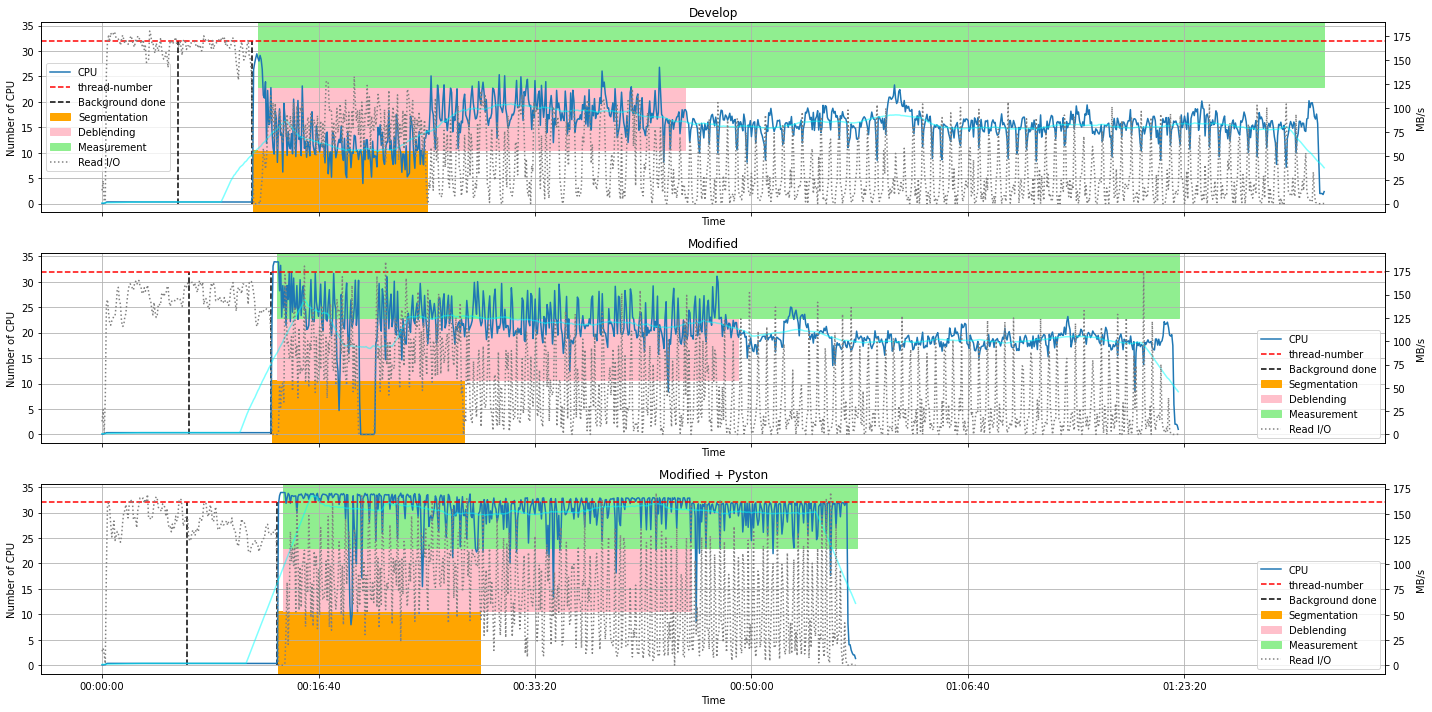

In [6]:
fig, axes = plt.subplots(nrows=3, sharex=True, sharey=True)
plot_perf(dev, dev_log, ax=axes[0])
axes[0].set_title('Develop')
plot_perf(mod, mod_log, ax=axes[1])
axes[1].set_title('Modified')
plot_perf(pyston, pyston_log, ax=axes[2])
axes[2].set_title('Modified + Pyston')
plt.tight_layout()